In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os
import cellpylib as cpl
import numpy as np
import os
from IPython.display import HTML,display
import json
#%matplotlib notebook
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'
plt.rcParams["animation.html"] = "jshtml"

In [75]:
def animate(data):
    n_frames = len(data)

    dims = np.shape(data)
    colorsData = np.zeros(dims)
    for i in range(min(dims)):
        colorsData[i, i] = i
    fig = plt.figure()
    plot = plt.matshow(data[len(data)-1], fignum=0)

    def init():
        plot.set_data(data[0])
        return [plot]

    def update(j):
        plot.set_data(data[j])
        return [plot]


    anim = animation.FuncAnimation(fig, update, init_func = init, frames=n_frames, interval = 30, blit=True)

    return anim
    #plt.show()

In [173]:
# initialize a 60x60 2D cellular automaton 
timesteps = 50
dim1 = 60
dim2 = 60
cellular_automaton = cpl.init_simple2d(dim1, dim2)


# evolve the cellular automaton for 30 time steps, 
#  applying totalistic rule 126 to each cell with a Moore neighbourhood
cellular_automaton = cpl.evolve2d(cellular_automaton, timesteps=timesteps, neighbourhood='Moore',
                                  apply_rule=lambda n, c, t: cpl.totalistic_rule(n, k=2, rule=126))
dirName = "data"
if os.path.exists(dirName):
    count = 0
    for file in os.listdir(dirName):
        if ".csv" in file:
            count += 1
            os.remove("{}/{}".format(dirName,file))
    print("{} csv deleted files".format(count))
else:
    print("The file does not exist")
if not os.path.exists(dirName):
    os.mkdir(dirName)
for i in range(timesteps):
    x = cellular_automaton[i]
    np.savetxt("{}/step_{}.csv".format(dirName,i),x,fmt='%d', delimiter=",")

30 csv deleted files


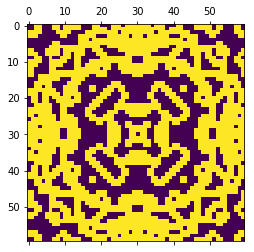

In [174]:
animate(cellular_automaton)

In [112]:
def plotCA(data,size=(20,10)):
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(data,plt.cm.Greys)
    plt.ylabel("steps",fontsize="large")
    for i in range(len(data)):
        for j in range(len(data[i])):
            c = "w"
            if data[i][j] <= 2:
                c = "black"
            text = ax.text(j, i, data[i][j],
                           ha="center", va="center", color=c,fontsize="large")
    plt.show()

def cpAp(e,lst):
    a = np.append(e,lst)
    return a

def aptitud(pos,neg,notapt,removedPos,removedNeg):
    pos_values = {}
    neg_values = {}
    onlykeys = {x[0] for x in notapt}
    jstr = [str(j) for j in range(len(pos[0]))]
    for s in jstr:
        pos_values[str(s)+",1"] = 0
        pos_values[str(s)+",0"] = 0
        neg_values[str(s)+",1"] = 0
        neg_values[str(s)+",0"] = 0
    
    for i in range(len(pos)):
        if i not in removedPos:
            for j,s in enumerate(jstr):
                if pos[i][j] == 1:
                    key = s+",1"
                else:
                    key = s+",0"
                if key not in onlykeys:
                    pos_values[key] += 1
    for i in range(len(neg)):
        if i not in removedNeg:
            for j,s in enumerate(jstr):
                if neg[i][j] == 1:
                    key = s+",1"
                else:
                    key = s+",0"
                if key not in onlykeys:
                    neg_values[key] += 1
    res = []
    for key in pos_values:
        if neg_values[key] == 0 and pos_values[key] > 0:
            res.append([key,1000*pos_values[key]])
        elif neg_values[key] > 0:
            res.append([key,pos_values[key]/neg_values[key]])
            
    res.sort(key=lambda x: x[1],reverse=True)
    mx = max(res, key=lambda x: x[1])
    res = list(filter(lambda x: x[1] == mx[1],res))
    return res

def removeBest(pos,key,removedPos):
    key = key.split(",")
    index = int(key[0])
    value = int(key[1])
    for i in range(len(pos)):
        if i not in removedPos:
            if pos[i][index] == value:
                removedPos[i] = True

def removeNeg(neg,t,removedNeg):
    newneg = []
    for i in range(len(neg)):
        if i not in removedNeg:
            add = False
            for j in range(len(t)):
                key = t[j]
                key = key.split(",")
                index = int(key[0])
                value = int(key[1])
                if neg[i][index] == value:
                    add = True
                    break
            if not add:
                removedNeg[i] = True

def ocat(data,m):
    neg = data["neg"]
    pos = data["pos"]
    C = []
    removedNeg = {}
    while len(neg) > len(removedNeg):
        t = []
        removedPos = {}
        notapt = []
        while len(pos) > len(removedPos):
            apt = aptitud(pos,neg,notapt,removedPos,removedNeg)
            if m >= len(apt):
                notapt = []
            else:
                notapt = apt[m:]
                apt = apt[:m]
            if len(apt) > 0:
                best = apt[random.randint(0,len(apt)-1)]
                t.append(best[0])
                removeBest(pos,best[0],removedPos)
        C.append(t)
        removeNeg(neg,t,removedNeg)
    return C

def dictToMat(dic):
    matrix = []
    for key in dic:
        for key2 in dic[key]:
            temp = copy(dic[key][key2])
            temp.append(key)
            matrix.append(temp)
    return matrix

def getDomain(data):
    #encontramos los valores observados de cada atributo en los subproblemas de aprendizaje
    domain = {}
    for row in data:
        for j,col in enumerate(row):
            if j not in domain:
                domain[j] = []
            if col not in domain[j]:
                domain[j].append(col)
    for key in domain:
        domain[key].sort()
    return domain

def binarize(data):
    #binarizamos los subproblemas de aprendizaje
    binarizedMatrix = []
    for row in data:
        rtemp = []
        for j,col in enumerate(row):
            if j < len(row)-1:
                for val in domain[j]:
                    if col >= val:
                        rtemp.append(1)
                    else:
                        rtemp.append(0)
            else:
                rtemp.append(col)
        binarizedMatrix.append(rtemp)
    return binarizedMatrix

def getPosNeg(domain,binarized):
    # obtenemos los ejemplos positivos y negativos para el atributo x[1] de los subproblemas
    keys = list(domain.keys())
    pos_neg = {}
    pos = {}
    for row in binarized:
        for val in domain[keys[-1]]:
            if val not in pos_neg:
                pos_neg[val] = {"pos":[],"neg":[]}
            if val not in pos:
                pos[val] = {}
            temp = "".join(map(str,row[:-1]))
            if val == row[-1]:
                if temp not in pos[val]:
                    pos_neg[val]["pos"].append(row[:-1])
                    pos[val][temp] = 0 
            else:
                if temp not in pos[val]:
                    pos_neg[val]["neg"].append(row[:-1])
                    pos[val][temp] = 0 
    return pos_neg

def getRules(posNeg,m):
    rules = {}
    for key in posNeg:
        if key not in rules:
            rules[key] = {}
        if len(posNeg[key]["pos"]) > 0 and len(posNeg[key]["neg"]) > 0:
            print("learning op ",key)
            rules[key] = ocat(posNeg[key],m)
    return rules

def binarizedToDomain(rules,domain):
    keys = list(domain.keys())
    oRules = {}
    for cls in rules:
        if cls not in oRules:
            oRules[cls] = {}
        prop = []
        for clause in rules[cls]:
            expr = []
            for term in clause:
                col = 0
                ind = int(term.split(",")[0])
                val = int(term.split(",")[1])
                bottom = 0
                for key in keys:
                    if ind >= bottom and ind <= (bottom + len(domain[key])):
                        col = key
                        ind -= bottom
                        break
                    bottom += len(domain[key])
                relational = (">=" if val== 1 else "<")
                t = "A[{}] {} {}".format(col,relational,domain[col][ind])
                expr.append(t)
            prop.append("({})".format(" or ".join(expr)))
        oRules[cls] = " and ".join(prop)
    return oRules

def getNeighborsWithRadious(dataframe,r):
    #creamos un problema de aprendizaje para cada celda
    neighbors = {}
    for i,row in dataframe.iterrows():
        for j in range(len(dataframe.columns)):
            if j not in neighbors:
                neighbors[j] = []
            temp = []
            for x in range(1,(r+1)):
                if (j-x) < 0:
                    temp.append(0)
                else:
                    temp.append(row[j-x])
            temp.append(row[j])
            for x in range(1,(r+1)):
                if (j+x) >= len(dataframe.columns):
                    temp.append(0)
                else:
                    temp.append(row[j+x])
            neighbors[j].append(temp)
    return neighbors

def getClassState(neighbors):
    problem = {}
    for col in neighbors:
        for row in range(1,len(neighbors[col])):
            icenter = floor(len(neighbors[col][row])/2)
            if neighbors[col][row][icenter] not in problem:
                problem[neighbors[col][row][icenter]] = {}
            k = ",".join(map(str,neighbors[col][row-1]))
            if k not in problem[neighbors[col][row][icenter]]:
                problem[neighbors[col][row][icenter]][k] = neighbors[col][row-1]
    return problem

#returns an expression to get the transformed coordinates 
# from the original dimensions to the 1 dimension flattened data
def getExpr(size):
    val = ""
    lst = []
    if len(size) > 1:
        for i in range(1,len(size)):
            temp = "xi[{}]".format(i-1)
            for j in range(i,len(size)):
                temp += "*{}".format(size[j])
            lst.append(temp)
    else:
        i = 0
    val += "+".join(lst)
    val += "+xi[{}]".format(i)
    return val

#returns an array with the position in the flattened data
#coords is an array with coordinate relative to the cell in the original dimensions
# size = np.shape(data)
def getNeighbors(cell,coords,size):
    newCoords = []
    expr = getExpr(size)
    for coord in coords:
        xi = []
        outOfBounds = False
        for i,c in enumerate(cell):
            if type(coord) != int:
                v = c+coord[i]
                if v >= size[i] or v < 0:
                    outOfBounds = True
                else:
                    xi.append(v)
            else:
                v = c+coord
                if v >= size[0] or v < 0:
                    outOfBounds = True
                else:
                    xi.append(c+coord)
        if outOfBounds:
            newCoords.append(-1)
        else:
            newCoord = eval(expr)
            newCoords.append(newCoord)
            
    return newCoords

#returns the values of the neighbors of a certain cell
#data = flattened array of the data
#neighbors = the positions of neighbors of a certain cell
#paddingtype = 0 => don't get values,1=> fill with padding value, 2 => don't fill and return empty dict
#paddingvalue = the values to fill when the padding type equals 1
def getNeighborsValue(data,neighbors,paddingType = 0,paddingValue=0):
    values = {}
    for i,n in enumerate(neighbors):
        val = None
        if n >= 0 and n < len(data):
            val = data[n]
        else:
            if paddingType == 0: continue
            elif paddingType == 1:
                val = paddingValue
            elif paddingType == 2:
                values = None
                break
        if val != None:
            values[i] = val
    return values

''' 
Example
data = np.array([[1,2,3],[4,5,6],[7,8,9]])
neighbors = getNeighbors([1,0],[[-1,-1],[0,-1],[1,-1]],np.shape(data))
print(data.reshape(-1))
print(neighbors)
print(getNeighborsValue(data.reshape(-1),neighbors,1,1))

ouput:
[1 2 3 4 5 6 7 8 9]
[-1, 2, 5]
{-1: 1, 2: 3, 5: 6}
'''

' \nExample\ndata = np.array([[1,2,3],[4,5,6],[7,8,9]])\nneighbors = getNeighbors([1,0],[[-1,-1],[0,-1],[1,-1]],np.shape(data))\nprint(data.reshape(-1))\nprint(neighbors)\nprint(getNeighborsValue(data.reshape(-1),neighbors,1,1))\n\nouput:\n[1 2 3 4 5 6 7 8 9]\n[-1, 2, 5]\n{-1: 1, 2: 3, 5: 6}\n'

## Preprocesamiento

In [80]:
kernel = [[-1,-1],[0,-1],[1,-1],
              [-1,0],[0,0],[1,0],
              [-1,1],[0,1],[1,1]]
paddingType = 1
paddingValue = 0
dirName = "clean/"
if not os.path.exists(dirName):
    os.mkdir(dirName)
else:
    count = 0
    for file in os.listdir(dirName):
        if ".csv" in file:
            count += 1
            os.remove("{}/{}".format(dirName,file))
    print("{} csv deleted files".format(count))
#i = 1
dim = 0
for step in range(1,timesteps):
    df1 = pd.read_csv("data/step_{}.csv".format(step-1),header=None).values
    df2 = pd.read_csv("data/step_{}.csv".format(step),header=None).values
    dim = df1.shape
    planned = df1.reshape(-1) 
    processed = []
    for i in range(dim[0]):
        for j in range(dim[1]):
            neighbors = getNeighbors([i,j],kernel,dim)
            values = getNeighborsValue(planned,neighbors,paddingType,paddingValue)
            if values != None:
                temp = []
                for key in values:
                    temp.append(values[key])
                temp.append(df2[i][j])
                processed.append(temp)
    np.savetxt(dirName+str(step)+".csv", processed,fmt="%d", delimiter=",")

29 csv deleted files


In [81]:
configuration = {"kernel":kernel,"dimension":dim, "paddingType":paddingType,"paddingValue":paddingValue,"steps":timesteps}
configuration

{'kernel': [[-1, -1],
  [0, -1],
  [1, -1],
  [-1, 0],
  [0, 0],
  [1, 0],
  [-1, 1],
  [0, 1],
  [1, 1]],
 'dimension': (60, 60),
 'paddingType': 1,
 'paddingValue': 0,
 'steps': 30}

In [82]:
with open("config.json", "w") as write_file:
    json.dump(configuration, write_file)

### One dimension

In [165]:
cellular_automaton = np.array([[0,0,0,1,1,0,0,0]])#cpl.init_random(8)
 
# Mitchell et al. discovered this rule using a Genetic Algorithm
rule_number = 93

# evolve the CA, setting r to 3, for a neighbourhood size of 7
cellular_automaton = cpl.evolve(cellular_automaton, timesteps=20,
                                apply_rule=lambda n, c, t: cpl.binary_rule(n, rule_number), r=1)

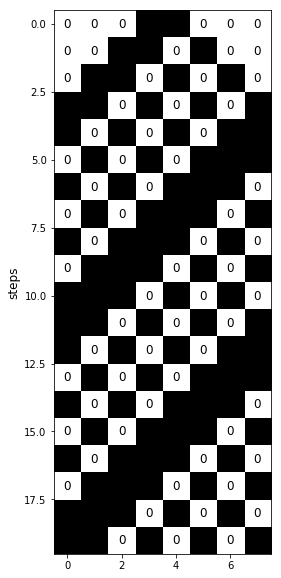

In [166]:
plotCA(cellular_automaton)

In [149]:
np.savetxt("{}.csv".format(rule_number), cellular_automaton,fmt="%d", delimiter=",")

In [168]:
for i in range(255):
    cellular_automaton = cpl.init_random(10)
 
    # Mitchell et al. discovered this rule using a Genetic Algorithm
    rule_number = i

    # evolve the CA, setting r to 3, for a neighbourhood size of 7
    cellular_automaton = cpl.evolve(cellular_automaton, timesteps=30,
                                    apply_rule=lambda n, c, t: cpl.binary_rule(n, rule_number), r=1)
    np.savetxt("{}.csv".format(rule_number), cellular_automaton,fmt="%d", delimiter=",")
    
    cellular_automaton = np.array([[0,0,1,0,1,1,0,0,1,0]])
    # Mitchell et al. discovered this rule using a Genetic Algorithm
    rule_number = i

    # evolve the CA, setting r to 3, for a neighbourhood size of 7
    cellular_automaton = cpl.evolve(cellular_automaton, timesteps=30,
                                    apply_rule=lambda n, c, t: cpl.binary_rule(n, rule_number), r=1)
    np.savetxt("control_{}.csv".format(rule_number), cellular_automaton,fmt="%d", delimiter=",")

In [203]:
cellular_automaton = cpl.init_random(50)
 
# Mitchell et al. discovered this rule using a Genetic Algorithm
rule_number = 32

# evolve the CA, setting r to 3, for a neighbourhood size of 7
cellular_automaton = cpl.evolve(cellular_automaton, timesteps=100,
                                apply_rule=lambda n, c, t: cpl.binary_rule(n, rule_number), r=1)

In [220]:
cellular_automaton2 = cpl.init_random(50)
 
# Mitchell et al. discovered this rule using a Genetic Algorithm
rule_number = 218

# evolve the CA, setting r to 3, for a neighbourhood size of 7
cellular_automaton2 = cpl.evolve(cellular_automaton2, timesteps=100,
                                apply_rule=lambda n, c, t: cpl.binary_rule(n, rule_number), r=1)

In [205]:
cellular_automaton3 = cpl.init_random(50)
 
# Mitchell et al. discovered this rule using a Genetic Algorithm
rule_number = 126

# evolve the CA, setting r to 3, for a neighbourhood size of 7
cellular_automaton3 = cpl.evolve(cellular_automaton3, timesteps=100,
                                apply_rule=lambda n, c, t: cpl.binary_rule(n, rule_number), r=1)

In [270]:
cellular_automaton4 = np.array([[0 for x in range(0,50)]])#cpl.init_random(50)
for i in range(15,35):
    cellular_automaton4[0][i] = (0 if np.random.randint(0,11) < 6 else 1 )
#cellular_automaton4[0][:20] = 0
#cellular_automaton4[0][30:] = 0
# Mitchell et al. discovered this rule using a Genetic Algorithm
rule_number = 110

# evolve the CA, setting r to 3, for a neighbourhood size of 7
cellular_automaton4 = cpl.evolve(cellular_automaton4, timesteps=100,
                                apply_rule=lambda n, c, t: cpl.binary_rule(n, rule_number), r=1)

In [261]:
def animateOneCA(cellular_automaton):
    shape = [len(cellular_automaton)] + list(np.shape(cellular_automaton))
    animationData = np.zeros(shape=shape)
    for i,row in enumerate(cellular_automaton):
        for j in range(0,i+1):
            animationData[i][j] = cellular_automaton[j]
    return animationData

In [271]:
class1 = animateOneCA(cellular_automaton)
class2 = animateOneCA(cellular_automaton2)
class3 = animateOneCA(cellular_automaton3)
class4 = animateOneCA(cellular_automaton4)

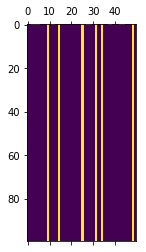

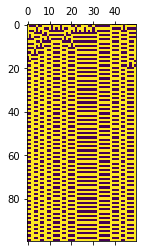

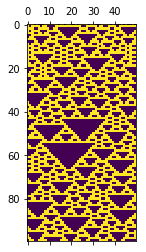

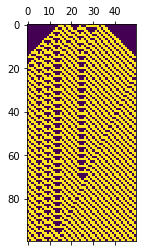

In [272]:
anim1 = animate(class1)
anim2 = animate(class2)
anim3 = animate(class3)
anim4 = animate(class4)
anim1.save("class1.mp4",fps=5)
anim2.save("class2.mp4",fps=5)
anim3.save("class3.mp4",fps=5)
anim4.save("class4.mp4",fps=5)